# Guide pour l'Appel à une API Hugging Face pour la Segmentation d'Images

Bienvenue ! Ce notebook a pour but de vous guider pas à pas dans l'utilisation de l'API d'inférence de Hugging Face pour effectuer de la segmentation d'images. La segmentation d'images consiste à attribuer une étiquette (comme "cheveux", "vêtement", "arrière-plan") à chaque pixel d'une image.

Nous allons :
1. Comprendre ce qu'est une API et comment s'y connecter.
2. Envoyer une image à un modèle de segmentation hébergé sur Hugging Face.
3. Récupérer et interpréter les résultats.
4. Visualiser les masques de segmentation.
5. Étendre cela pour traiter plusieurs images.

## 1. Configuration Initiale et Importations

Commençons par importer les bibliothèques Python nécessaires. Nous aurons besoin de :
- `os` pour interagir avec le système de fichiers (lister les images).
- `requests` pour effectuer des requêtes HTTP vers l'API.
- `PIL (Pillow)` pour manipuler les images.
- `matplotlib.pyplot` pour afficher les images et les masques.
- `numpy` pour la manipulation des tableaux (les images sont des tableaux de pixels).
- `tqdm.notebook` pour afficher une barre de progression (utile pour plusieurs images).
- `base64` et `io` pour décoder les masques renvoyés par l'API.

In [46]:
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import base64
import io
from dotenv import load_dotenv

load_dotenv()

api_token = os.getenv("HUGGING_FACE_API_TOKEN")
model_name = os.getenv("HUGGING_FACE_MODEL_NAME")

### Variables de Configuration

Nous devons définir quelques variables :
- `image_dir`: Le chemin vers le dossier contenant vos images. **Assurez-vous de modifier ce chemin si nécessaire.**
- `max_images`: Le nombre maximum d'images à traiter (pour ne pas surcharger l'API ou attendre trop longtemps).
- `api_token`: Votre jeton d'API Hugging Face. **IMPORTANT : Gardez ce jeton secret !**

**Comment obtenir un token API Hugging Face ?**
1. Créez un compte sur [huggingface.co](https://huggingface.co/).
2. Allez dans votre profil -> Settings -> Access Tokens.
3. Créez un nouveau token (par exemple, avec le rôle "read").
4. Copiez ce token ici.

In [47]:
# TODO: Modifiez ces valeurs selon votre configuration
image_dir = "./img/"  # Exemple : si vous êtes sur Colab et avez uploadé un dossier
max_images = 50  # Commençons avec peu d'images

# Créons le dossier d'images s'il n'existe pas (pour l'exemple)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    print(f"Dossier '{image_dir}' créé. Veuillez y ajouter des images .jpg ou .png.")
else:
    print(f"Dossier '{image_dir}' existant.")

if api_token == "VOTRE_TOKEN_HUGGING_FACE_ICI":
    print("\nATTENTION : Vous devez remplacer 'VOTRE_TOKEN_HUGGING_FACE_ICI' par votre token API personnel.")

Dossier './img/' existant.


## 2. Comprendre l'API d'Inférence Hugging Face

L'API d'inférence permet d'utiliser des modèles hébergés sur Hugging Face sans avoir à les télécharger ou à gérer l'infrastructure.

- **Modèle utilisé** : Nous allons utiliser le modèle `sayeed99/segformer_b3_clothes`, spécialisé dans la segmentation de vêtements et de parties du corps.
- **URL de l'API** : L'URL pour un modèle est généralement `https://api-inference.huggingface.co/models/NOM_DU_MODELE`.
- **Headers (En-têtes)** : Pour s'authentifier et spécifier le type de contenu, nous envoyons des en-têtes avec notre requête.
    - `Authorization`: Contient notre token API (précédé de `Bearer `).
    - `Content-Type`: Indique que nous envoyons une image au format JPEG (ou PNG selon le cas).

In [48]:
API_URL = f"https://router.huggingface.co/hf-inference/models/{model_name}" # Remplacez ... par le bon endpoint.
headers = {
    "Authorization": f"Bearer {api_token}"
    # Le "Content-Type" sera ajouté dynamiquement lors de l'envoi de l'image
}

# Lister les chemins des images à traiter
# Assurez-vous d'avoir des images dans le dossier 'image_dir'!
image_paths = [f"{image_dir}image_{i}.png" for i in range(max_images)]

if not image_paths:
    print(f"Aucune image trouvée dans '{image_dir}'. Veuillez y ajouter des images.")
else:
    print(f"{len(image_paths)} image(s) à traiter : {image_paths}")

50 image(s) à traiter : ['./img/image_0.png', './img/image_1.png', './img/image_2.png', './img/image_3.png', './img/image_4.png', './img/image_5.png', './img/image_6.png', './img/image_7.png', './img/image_8.png', './img/image_9.png', './img/image_10.png', './img/image_11.png', './img/image_12.png', './img/image_13.png', './img/image_14.png', './img/image_15.png', './img/image_16.png', './img/image_17.png', './img/image_18.png', './img/image_19.png', './img/image_20.png', './img/image_21.png', './img/image_22.png', './img/image_23.png', './img/image_24.png', './img/image_25.png', './img/image_26.png', './img/image_27.png', './img/image_28.png', './img/image_29.png', './img/image_30.png', './img/image_31.png', './img/image_32.png', './img/image_33.png', './img/image_34.png', './img/image_35.png', './img/image_36.png', './img/image_37.png', './img/image_38.png', './img/image_39.png', './img/image_40.png', './img/image_41.png', './img/image_42.png', './img/image_43.png', './img/image_44.p

## 3. Fonctions Utilitaires pour le Traitement des Masques

Le modèle que nous utilisons (`sayeed99/segformer_b3_clothes`) renvoie des masques pour différentes classes (cheveux, chapeau, etc.). Ces masques sont encodés en base64. Les fonctions ci-dessous sont fournies pour vous aider à :
1.  `CLASS_MAPPING`: Un dictionnaire qui associe les noms de classes (ex: "Hat") à des identifiants numériques.
2.  `get_image_dimensions`: Récupérer les dimensions d'une image.
3.  `decode_base64_mask`: Décoder un masque de base64 en une image (tableau NumPy) et le redimensionner.
4.  `create_masks`: Combiner les masques de toutes les classes détectées en un seul masque de segmentation final, où chaque pixel a la valeur de l'ID de sa classe.

**Cette partie est donnée car elle est spécifique au format de sortie de ce modèle et un peu complexe pour une première approche.** Lisez-la pour comprendre son rôle, mais ne vous attardez pas sur les détails d'implémentation pour l'instant.

In [49]:
CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}

def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.

    Args:
        img_path (str): Path to the image.

    Returns:
        tuple: (width, height) of the image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def decode_base64_mask(base64_string, width, height):
    """
    Decode a base64-encoded mask into a NumPy array.

    Args:
        base64_string (str): Base64-encoded mask.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Single-channel mask array.
    """
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]  # Take first channel if RGB
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.

    Args:
        results (list): List of dictionaries with 'label' and 'mask' keys.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Combined segmentation mask with class indices.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize with Background (0)

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background
            continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

    # Process Background last to ensure it doesn't overwrite other classes unnecessarily
    # (Though the model usually provides non-overlapping masks for distinct classes other than background)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            # Apply background only where no other class has been assigned yet
            # This logic might need adjustment based on how the model defines 'Background'
            # For this model, it seems safer to just let non-background overwrite it first.
            # A simple application like this should be fine: if Background mask says pixel is BG, set it to 0.
            # However, a more robust way might be to only set to background if combined_mask is still 0 (initial value)
            combined_mask[mask_array > 0] = 0 # Class ID for Background is 0

    return combined_mask

## 4. Segmentation d'une Seule Image

Avant de traiter toutes les images, concentrons-nous sur une seule pour bien comprendre le processus.

Étapes :
1.  Choisir une image.
2.  Ouvrir l'image en mode binaire (`"rb"`) et lire son contenu (`data`).
3.  Déterminer le `Content-Type` (par exemple, `"image/jpeg"` ou `"image/png"`).
4.  Envoyer la requête POST à l'API avec `requests.post()` en passant l'URL, les headers et les données.
5.  Vérifier le code de statut de la réponse. Une erreur sera levée si le code n'est pas 2xx (succès) grâce à `response.raise_for_status()`.
6.  Convertir la réponse JSON en un dictionnaire Python avec `response.json()`.
7.  Utiliser nos fonctions `get_image_dimensions` et `create_masks` pour obtenir le masque final.
8.  Afficher l'image originale et le masque segmenté.

Traitement de l'image : ./img/image_0.png


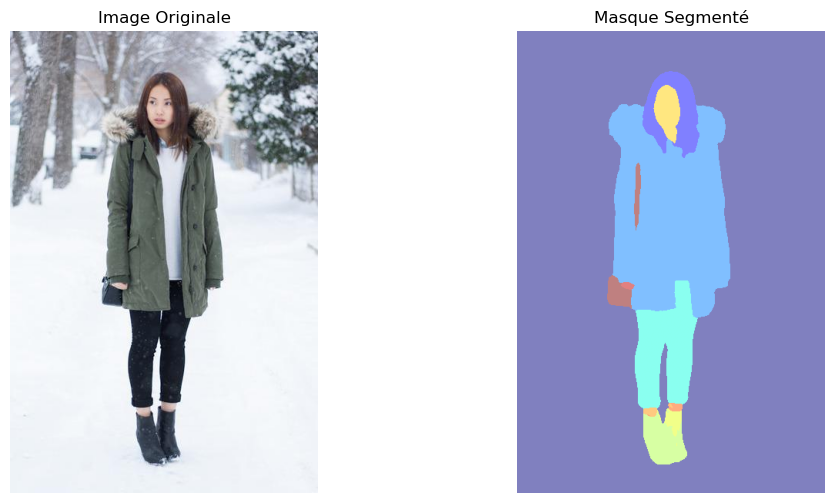

In [50]:
if image_paths:
    single_image_path = image_paths[0]  # Prenons la première image de notre liste
    print(f"Traitement de l'image : {single_image_path}")

    try:
        # Lire l'image en mode binaire
        with open(single_image_path, "rb") as img_file:
            image_data = img_file.read()

        # Déterminer le Content-Type
        if single_image_path.endswith(".jpg") or single_image_path.endswith(".jpeg"):
            content_type = "image/jpeg"
        elif single_image_path.endswith(".png"):
            content_type = "image/png"
        else:
            raise ValueError("Type de fichier non supporté.")

        # Envoyer la requête POST à l'API
        headers['Content-Type'] = content_type

        response = requests.post(API_URL, headers=headers, data=image_data)

        # Vérifier le code de statut de la réponse
        response.raise_for_status()  # Cela lèvera une erreur si le statut n'est pas 2xx

        # Convertir la réponse JSON en un dictionnaire Python
        response_json = response.json()

        # Utiliser vos fonctions pour obtenir le masque final
        width, height = get_image_dimensions(single_image_path)

        # Créer le masque
        combined_mask = create_masks(response_json, width, height)

        original_image = Image.open(single_image_path)

        # Afficher les deux images
        plt.figure(figsize=(12, 6))

        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Image Originale")
        plt.axis('off')

        # Masque segmenté
        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap='jet', alpha=0.5)  # Utilisez un cmap coloré pour le masque
        plt.title("Masque Segmenté")
        plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"Une erreur est survenue : {e}")
else:
    print("Aucune image à traiter. Vérifiez la configuration de 'image_dir' et 'max_images'.")

## 5. Segmentation de Plusieurs Images (Batch)

Maintenant que nous savons comment traiter une image, nous pouvons créer une fonction pour en traiter plusieurs.
Cette fonction va boucler sur la liste `image_paths` et appliquer la logique de segmentation à chaque image.
Nous utiliserons `tqdm` pour avoir une barre de progression.

In [ ]:
import time

def segment_images_batch(list_of_image_paths):
    """
    Segmente une liste d'images en utilisant l'API Hugging Face.

    Args:
        list_of_image_paths (list): Liste des chemins vers les images.

    Returns:
        list: Liste des masques de segmentation (tableaux NumPy).
              Contient None si une image n'a pas pu être traitée.
    """
    batch_segmentations = []

    # Boucle sur chaque image dans la liste
    for single_image_path in tqdm(list_of_image_paths, desc="Segmentation des images"):
        print(f"Traitement de l'image : {single_image_path}")  # Optionnel: Afficher l'image en cours de traitement

        try:
            with open(single_image_path, "rb") as img_file:
                image_data = img_file.read()

            if single_image_path.endswith(".jpg") or single_image_path.endswith(".jpeg"):
                content_type = "image/jpeg"
            elif single_image_path.endswith(".png"):
                content_type = "image/png"
            else:
                print(f"Type de fichier non supporté pour {single_image_path}.")
                batch_segmentations.append(None)  # Ajouter None si le type de fichier est non supporté
                continue

            headers['Content-Type'] = content_type
            response = requests.post(API_URL, headers=headers, data=image_data)
            response.raise_for_status()  # Vérifier le statut de la réponse

            response_json = response.json()
            width, height = get_image_dimensions(single_image_path)
            combined_mask = create_masks(response_json, width, height)

            batch_segmentations.append(combined_mask)  # Ajouter le masque obtenu à la liste

        except Exception as e:
            print(f"Une erreur est survenue lors du traitement de l'image {single_image_path}: {e}")
            batch_segmentations.append(None)  # Ajouter None en cas d'erreur

        # Pause entre les appels pour éviter de surcharger l'API
        time.sleep(1)  # Ajustez la durée de la pause si nécessaire

    return batch_segmentations

# Appeler la fonction pour segmenter les images listées dans image_paths
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    batch_seg_results = segment_images_batch(image_paths)
    print("Traitement en batch terminé.")
else:
    batch_seg_results = []
    print("Aucune image à traiter en batch.")


Traitement de 50 image(s) en batch...


Segmentation des images:   0%|          | 0/50 [00:00<?, ?it/s]

Traitement de l'image : ./img/image_0.png


## 6. Affichage des Résultats en Batch

Nous allons maintenant créer une fonction pour afficher les images originales et leurs segmentations correspondantes côte à côte, dans une grille.

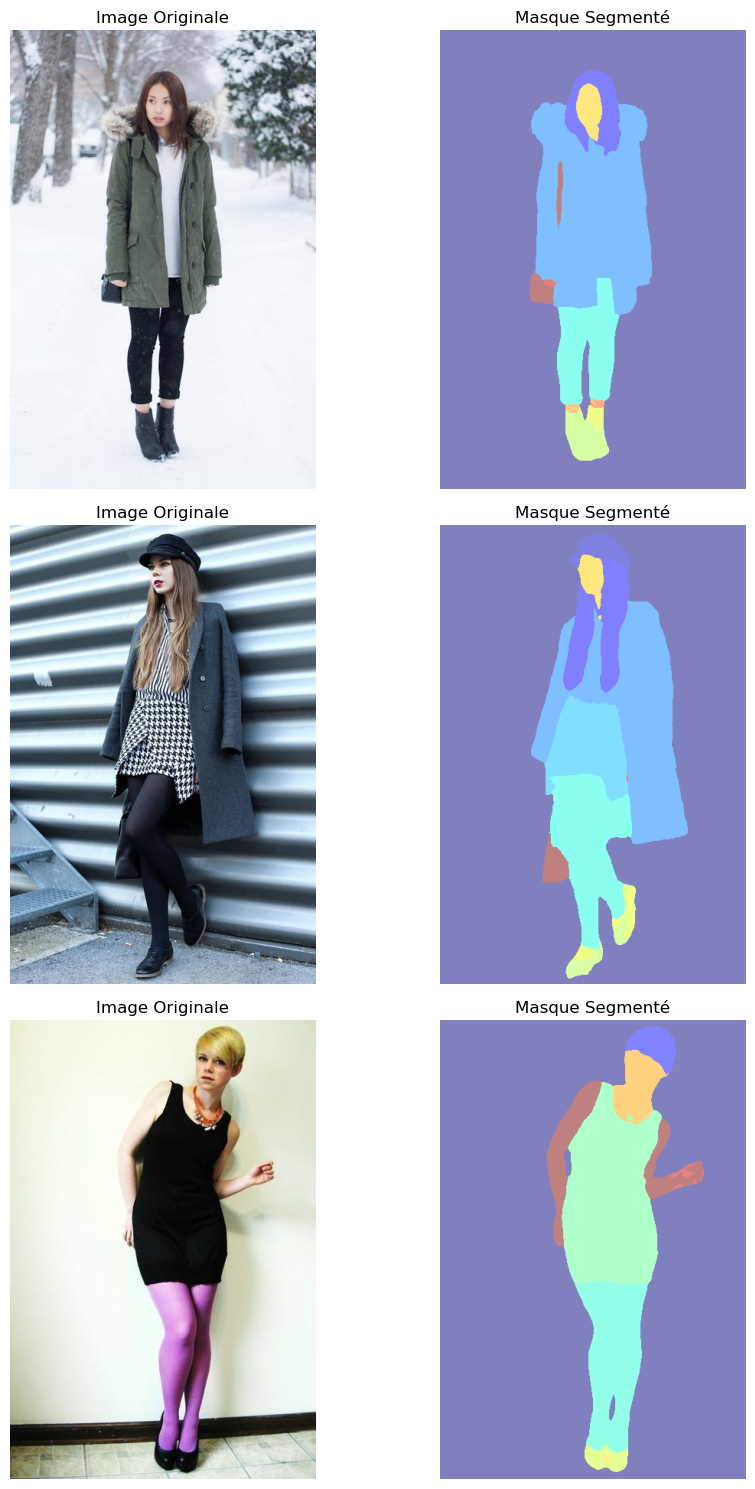

In [ ]:
def display_segmented_images_batch(original_image_paths, segmentation_masks):
    """
    Affiche les images originales et leurs masques segmentés.

    Args:
        original_image_paths (list): Liste des chemins des images originales.
        segmentation_masks (list): Liste des masques segmentés (NumPy arrays).
    """
    # New plot size based on the number of images
    num_images = len(original_image_paths)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

    for i in range(num_images):
        # Afficher l'image originale
        original_image = Image.open(original_image_paths[i])
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title("Image Originale")
        axes[i, 0].axis('off')

        # Afficher le masque segmenté
        mask = segmentation_masks[i]
        if mask is not None:
            axes[i, 1].imshow(mask, cmap='jet', alpha=0.5)  # Utilise un colormap pour le masque
            axes[i, 1].set_title("Masque Segmenté")
        else:
            axes[i, 1].imshow(np.zeros(mask.shape), cmap='gray')  # Afficher une image vide si le masque est None
            axes[i, 1].set_title("Masque Segmenté (Erreur lors du traitement)")

        axes[i, 1].axis('off')

    # Ajuster l'espacement entre les images
    plt.tight_layout()
    plt.show()

# Afficher les résultats du batch
if batch_seg_results:
    display_segmented_images_batch(image_paths, batch_seg_results)
else:
    print("Aucun résultat de segmentation à afficher.")

## Conclusion et Prochaines Étapes

Félicitations ! Vous avez appris à :
- Configurer les appels à l'API d'inférence Hugging Face.
- Envoyer des images pour la segmentation.
- Interpréter les résultats (avec l'aide des fonctions fournies).
- Visualiser les segmentations.

Pistes d'amélioration ou d'exploration :
- **Gestion d'erreurs plus fine** : Implémenter des tentatives multiples (retry) en cas d'échec de l'API (par exemple, si le modèle est en cours de chargement).
- **Appels asynchrones** : Pour un grand nombre d'images, des appels asynchrones (avec `asyncio` et `aiohttp`) seraient beaucoup plus rapides.
- **Autres modèles** : Explorer d'autres modèles de segmentation ou d'autres tâches sur Hugging Face Hub.

N'hésitez pas à modifier le code, à tester avec vos propres images et à explorer davantage !

**_Note_** : Si vous aimez ce modèle, n'hésitez pas à le [télécharger](https://huggingface.co/sayeed99/segformer_b3_clothes) et jouer avec directement sur votre machine !